> ### Analizador de hemorragia intracraneal
> ## UVG (EAUG)

In [ ]:
from numpy.random import seed
seed(101)

import pandas as pd
import numpy as np


import os
import cv2

import imageio
import skimage
import skimage.io
import skimage.transform

from skimage.io import imread, imshow
from skimage.transform import resize


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:

IMAGE_HEIGHT_ORIG = 650
IMAGE_WIDTH_ORIG = 650

NUM_TEST_IMAGES = 10

IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
IMAGE_CHANNELS = 3

BATCH_SIZE = 10


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Kaggle

In [ ]:
%%capture

# Uninstall and reinstall kaggle

!pip uninstall -y kaggle
!pip install kaggle

In [ ]:
# API.
os.environ["KAGGLE_USERNAME"] = 'vbookshelf'
os.environ["KAGGLE_KEY"] = 'f14e2382c2256641fed75636354016de'

In [ ]:
#dataset


raw_data_dir = "input/raw"


!kaggle datasets download -d vbookshelf/computed-tomography-ct-images -p {raw_data_dir}

 93% 84.0M/90.2M [00:00<00:00, 55.5MB/s]
100% 90.2M/90.2M [00:00<00:00, 106MB/s] 


In [ ]:

!ls {raw_data_dir}

computed-tomography-ct-images.zip


## Set up de fuze-zip


In [ ]:
%%capture

!apt-get install -y fuse-zip

In [ ]:

%%time

input_dir = "/tmp/kaggle-data"
!mkdir {input_dir}
!fuse-zip input/raw/computed-tomography-ct-images.zip {input_dir}

CPU times: user 38.2 ms, sys: 19.3 ms, total: 57.5 ms
Wall time: 4.73 s


In [ ]:
!ls

gdrive	input  sample_data


In [ ]:

!ls {input_dir}

computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0


In [ ]:
path = '/tmp/kaggle-data/'
os.listdir(path)

['computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0']

In [ ]:


base_path = '/tmp/kaggle-data/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.0.0/'

os.listdir(base_path)

['LICENSE.txt',
 'Patients_CT',
 'README.txt',
 'SHA256SUMS.txt',
 'ct_ich.yml',
 'hemorrhage_diagnosis.csv',
 'patient_demographics.csv',
 'split_data.py']

## funciones de ayuda helper functions

In [ ]:
# augmentacion funciones

def augment_image_and_mask(augmentation, image, mask):
    
    """
 
    Uses the Albumentations library.
    
    Inputs: 
    1. augmentation - this is the instance of type of augmentation to do 
    e.g. aug_type = HorizontalFlip(p=1) 
    # p=1 is the probability of the transform being executed.
    
    2. image - image with shape (h,w)
    3. mask - mask with shape (h,w)
    
    Output:
    Augmented image as a numpy array.
    Augmented mask as a numpy array.
    
    """
    # gettrans como dic
    aug_image_dict =  augmentation(image=image, mask=mask)
    # matriz augmentaada
    image_matrix = aug_image_dict['image']
    
    mask_matrix = aug_image_dict['mask']
    
    return image_matrix, mask_matrix


## Decargas de paquetes

In [ ]:
%%capture

! pip install segmentation-models

## Preparar la data

In [ ]:
path = base_path + 'hemorrhage_diagnosis.csv'
df_diag = pd.read_csv(path)



def swap_target(x):
    if x == 0:
        return 1
    else:
        return 0

df_diag['Has_Hemorrhage'] = df_diag['No_Hemorrhage'].apply(swap_target)

df_diag = df_diag.drop('No_Hemorrhage', axis=1)

print(df_diag.shape)

df_diag.head()

(2501, 9)


PatientNumber  SliceNumber  ...  Fracture_Yes_No  Has_Hemorrhage
0             49            1  ...                0               0
1             49            2  ...                0               0
2             49            3  ...                0               0
3             49            4  ...                0               0
4             49            5  ...                0               0

[5 rows x 9 columns]

In [ ]:


index_to_drop = df_diag[(df_diag['PatientNumber'] == 84) & (df_diag['SliceNumber'] == 36)].index

index_to_drop = index_to_drop[0]

df_diag = df_diag.drop(index_to_drop, axis=0)


df_diag[df_diag.index == index_to_drop]

Empty DataFrame
Columns: [PatientNumber, SliceNumber, Intraventricular, Intraparenchymal, Subarachnoid, Epidural, Subdural, Fracture_Yes_No, Has_Hemorrhage]
Index: []

### Mas columnas

In [ ]:



def get_mask_fname(row):
    
    #if row['Has_Hemorrhage'] == 1:
        
    mask_id = str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    


df_diag['mask_fname'] = df_diag.apply(get_mask_fname, axis=1)


def new_mask_fname(row):
    
    #if row['Has_Hemorrhage'] == 1:
        
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '_HGE_Seg.jpg'
    return mask_id
    



df_diag['new_mask_fname'] = df_diag.apply(new_mask_fname, axis=1)


def assign_image_fname(row):
    
    image_fname = str(row['SliceNumber']) + '.jpg'
    
    return image_fname


df_diag['image_fname'] = df_diag.apply(assign_image_fname, axis=1)



def assign_new_fname(row):
         
    mask_id = str(row['PatientNumber']) + '_' + str(row['SliceNumber']) + '.jpg'
    
    return mask_id
    



df_diag['new_image_fname'] = df_diag.apply(assign_new_fname, axis=1)


df_diag.head()

PatientNumber  SliceNumber  ...  image_fname  new_image_fname
0             49            1  ...        1.jpg         49_1.jpg
1             49            2  ...        2.jpg         49_2.jpg
2             49            3  ...        3.jpg         49_3.jpg
3             49            4  ...        4.jpg         49_4.jpg
4             49            5  ...        5.jpg         49_5.jpg

[5 rows x 13 columns]

### Mover todas las máscaras a la misma carpeta

In [ ]:
path = base_path + 'Patients_CT'

folder_list = os.listdir(path)

len(folder_list)

82

In [ ]:

mask_dir = 'mask_dir'
os.mkdir(mask_dir)

In [ ]:


for folder_name in folder_list:
    

    patient_num = int(folder_name)
    

    df = df_diag[df_diag['PatientNumber'] == patient_num]
    

    df = df[df['Has_Hemorrhage'] == 1]
    

    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        

        new_fname = str(patient_num) + '_' + fname

        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)

        dst = os.path.join(mask_dir, new_fname)

        shutil.copyfile(src, dst)
        
 

len(os.listdir('mask_dir'))

318

In [ ]:


blank_mask = np.zeros((IMAGE_HEIGHT_ORIG, IMAGE_WIDTH_ORIG))


for folder_name in folder_list:

    patient_num = int(folder_name)

    df = df_diag[df_diag['PatientNumber'] == patient_num]

    df = df[df['Has_Hemorrhage'] == 0]  
    

    mask_list = list(df['mask_fname'])
    
    for fname in mask_list:
        
    
        new_fname = str(patient_num) + '_' + fname
        
        
        dst = os.path.join(mask_dir, new_fname)
      

        cv2.imwrite(dst, blank_mask)
        

len(os.listdir('mask_dir'))



2500

### Mover todas las imágenes de la ventana de cerebro a la misma carpeta

In [ ]:

brain_image_dir = 'brain_image_dir'
os.mkdir(brain_image_dir)

In [ ]:
for folder_name in folder_list:

    patient_num = int(folder_name)

    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    

    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        new_fname = str(patient_num) + '_' + fname
        

        path = base_path + 'Patients_CT/' + folder_name + '/brain'
        src = os.path.join(path, fname)
  
        dst = os.path.join(brain_image_dir, new_fname)
        shutil.copyfile(src, dst)
        
        

len(os.listdir('brain_image_dir'))

2500

### Mover todas las imágenes de la ventana de huesos a la misma carpeta

In [ ]:
bone_image_dir = 'bone_image_dir'
os.mkdir(bone_image_dir)

In [ ]:
for folder_name in folder_list:
    
    patient_num = int(folder_name)
    
    df = df_diag[df_diag['PatientNumber'] == patient_num]
    
    
    image_list = list(df['image_fname'])
    
    for fname in image_list:
        
        new_fname = str(patient_num) + '_' + fname
        
        path = base_path + 'Patients_CT/' + folder_name + '/bone'
        src = os.path.join(path, fname)
        dst = os.path.join(bone_image_dir, new_fname)
        shutil.copyfile(src, dst)
        
        
len(os.listdir('bone_image_dir'))

2500

## Print de mascara e imagenes

(650, 650)


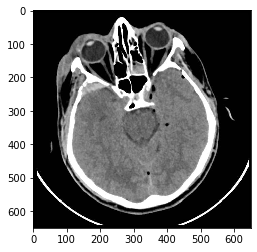

In [ ]:

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
brain_image = plt.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


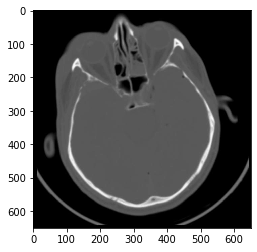

In [ ]:

fname = df_diag.loc[index, 'new_image_fname']
path = 'bone_image_dir/' + fname
bone_image = plt.imread(path)

print(bone_image.shape)

plt.imshow(bone_image, cmap='gray')

(650, 650)


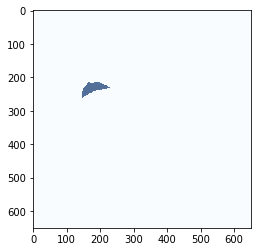

In [ ]:
# mascara (mask)

fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname
mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

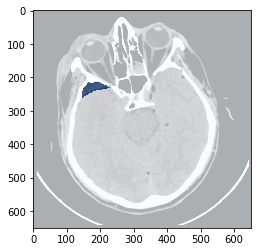

In [ ]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

## Set up - Augmentacion de data


In [ ]:
# Titulo: HOW TO DO MULTIPLE AUGMENTATIONS
# Extraido de: albumentation docs https://albumentations.ai/docs/examples/example_multi_target/

import albumentations as albu

# Define the augmentations

aug_types = albu.Compose([
    albu.HorizontalFlip(p=0.5),
    albu.OneOf([
        albu.RandomContrast(),
        albu.RandomGamma(),
        albu.RandomBrightness(),
        ], p=0.3),
    albu.OneOf([
        albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        albu.GridDistortion(),
        albu.OpticalDistortion(distort_limit=2, shift_limit=0.5),
        ], p=0.3),
    albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.5, border_mode=0),
])


# This how to call the function
# aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)

(650, 650, 3)


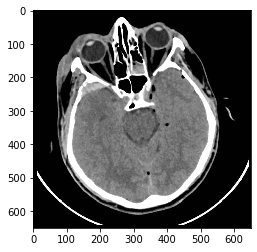

In [ ]:
#  imagen cerebro

index = 14
fname = df_diag.loc[index, 'new_image_fname']
path = 'brain_image_dir/' + fname
# leer como matiz 
brain_image = cv2.imread(path)

print(brain_image.shape)

plt.imshow(brain_image, cmap='gray')

(650, 650)


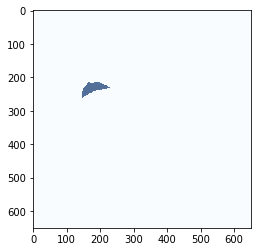

In [ ]:


fname = df_diag.loc[index, 'new_mask_fname']
path = 'mask_dir/' + fname

mask = plt.imread(path)

print(mask.shape)

plt.imshow(mask, cmap='Blues', alpha=0.7)

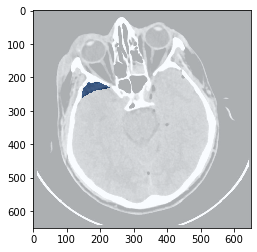

In [ ]:
plt.imshow(brain_image, cmap='gray')
plt.imshow(mask, cmap='Blues', alpha=0.7)

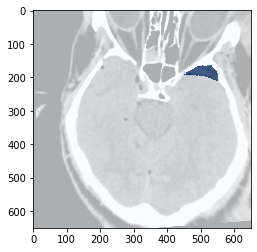

In [ ]:


# agumentacion
aug_image, aug_mask = augment_image_and_mask(aug_types, brain_image, mask)



plt.imshow(aug_image, cmap='gray')
plt.imshow(aug_mask, cmap='Blues', alpha=0.7)

### Display a ramdom sample of images from each dataset by target

In [ ]:
# Extraido de: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Dar una columna en un marco de datos,
    esta función toma una muestra de cada clase y muestra que
    muestra en una fila. El tamaño de la muestra es el mismo que figure_cols que
    es el número de columnas en la figura.
    Debido a que esta función toma una muestra aleatoria, cada vez que se ejecuta la función
    muestra diferentes imágenes.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_image_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
   
  
  
def draw_category_masks(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Dar una columna en un marco de datos,
    esta función toma una muestra de cada clase y muestra que
    muestra en una fila. El tamaño de la muestra es el mismo que figure_cols que
    es el número de columnas en la figura.
    Debido a que esta función toma una muestra aleatoria, cada vez que se ejecuta la función
    muestra diferentes imágenes.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['new_mask_fname']
            im=imageio.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=14)  
    plt.tight_layout()
    plt.show()
    

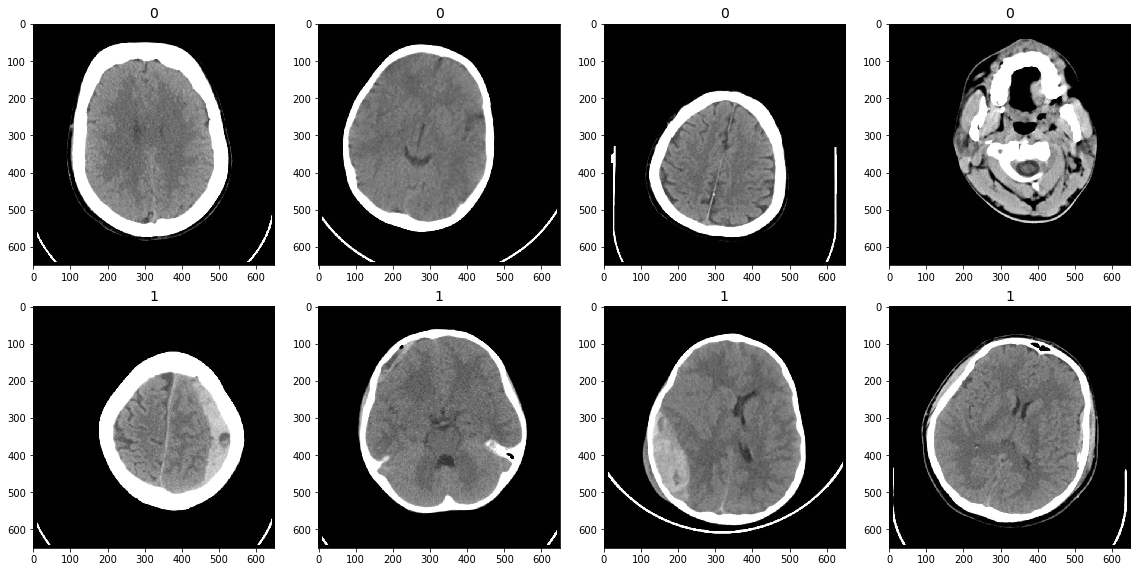

In [ ]:
# Cerebro imagen

IMAGE_PATH = 'brain_image_dir/'

draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

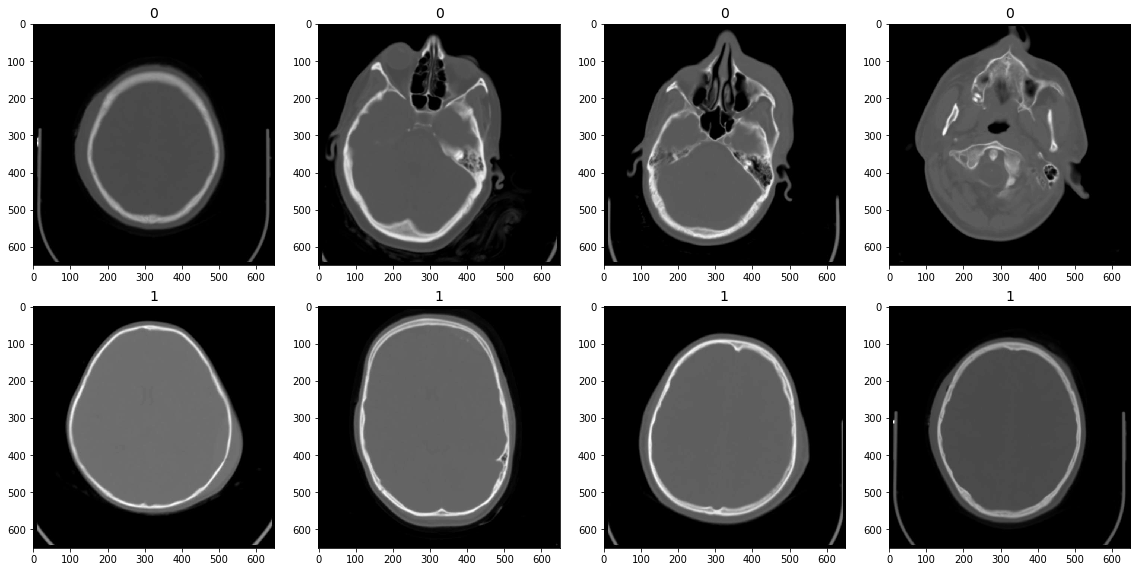

In [ ]:
# hueso imagen

IMAGE_PATH = 'bone_image_dir/'

draw_category_images('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

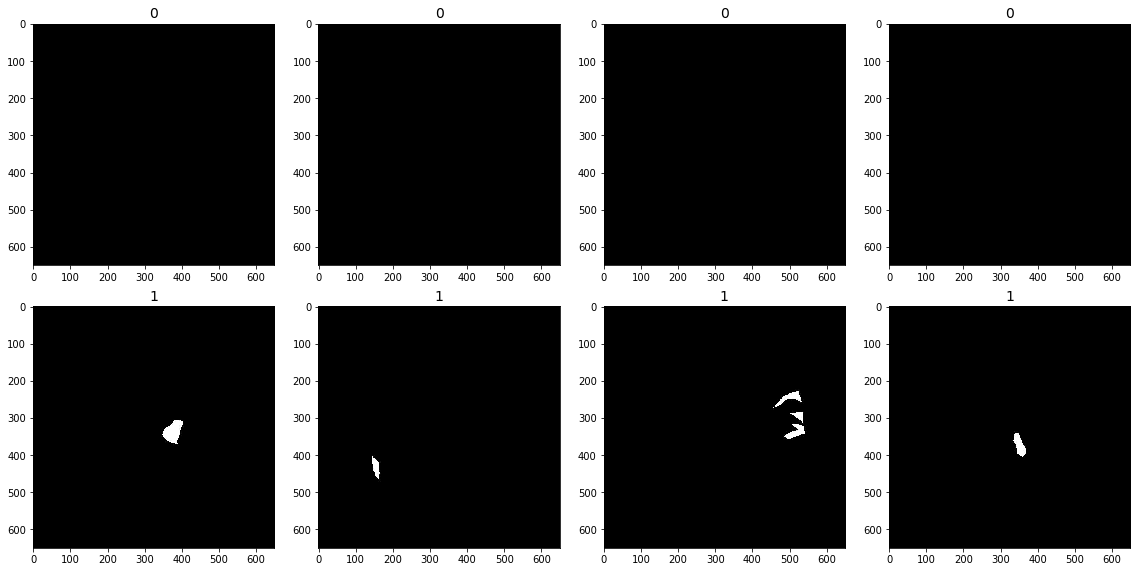

In [ ]:
# Masks

IMAGE_PATH = 'mask_dir/'

draw_category_masks('Has_Hemorrhage',4, df_diag, IMAGE_PATH)

## Crear un conjunto de prueba de reserva

Esto se reservará y no se utilizará durante el entrenamiento y la validación. Lo usaremos más adelante para verificar cómo se desempeña el modelo entrenado en datos no vistos.

In [ ]:
NUM_TEST_IMAGES = 10


#  10 sin hemo

df = df_diag[df_diag['Has_Hemorrhage'] == 0]

df_no_hem = df.sample(NUM_TEST_IMAGES, random_state=101)

# Reset 
df_no_hem = df_no_hem.reset_index(drop=True)

# Lista
test_images_list = list(df_no_hem['new_mask_fname'])



df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]




df = df_diag[df_diag['Has_Hemorrhage'] == 1]

df_with_hem = df.sample(NUM_TEST_IMAGES, random_state=102)


df_with_hem = df_with_hem.reset_index(drop=True)


test_images_list = list(df_with_hem['new_mask_fname'])



df_diag = df_diag[~df_diag['new_mask_fname'].isin(test_images_list)]



df_test = pd.concat([df_with_hem, df_no_hem], axis=0).reset_index(drop=True)



print(df_diag.shape)
print(df_test.shape)

(2480, 13)
(20, 13)


In [ ]:
df_test.head()

PatientNumber  SliceNumber  ...  image_fname  new_image_fname
0             49           20  ...       20.jpg        49_20.jpg
1             50           26  ...       26.jpg        50_26.jpg
2             81           16  ...       16.jpg        81_16.jpg
3             49           27  ...       27.jpg        49_27.jpg
4             70           13  ...       13.jpg        70_13.jpg

[5 rows x 13 columns]

## Train Test Split 
### Extraido de: https://www.geeksforgeeks.org/how-to-do-train-test-split-using-sklearn-in-python/


In [ ]:
# train_test_split


# shuffle
df_diag = shuffle(df_diag)

# reset the index
df_diag = df_diag.reset_index(drop=True)

# We will stratify by target
y = df_diag['Has_Hemorrhage']

df_train, df_val = train_test_split(df_diag, test_size=0.15, random_state=107, stratify=y)

print(df_train.shape)
print(df_val.shape)

(2108, 13)
(372, 13)


In [ ]:
df_train['Has_Hemorrhage'].value_counts()

0    1846
1     262
Name: Has_Hemorrhage, dtype: int64

In [ ]:
df_val['Has_Hemorrhage'].value_counts()

0    326
1     46
Name: Has_Hemorrhage, dtype: int64

## DF a CSV


para pandas

In [ ]:
df_diag.to_csv('df_data.csv.gz', compression='gzip', index=False)

df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)

df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)


In [ ]:

!ls

bone_image_dir	 df_data.csv.gz  df_train.csv.gz  gdrive  mask_dir
brain_image_dir  df_test.csv.gz  df_val.csv.gz	  input   sample_data


## Construir DG


La salida de un generador no se acumula en la memoria. Cada lote de salida sobrescribe el último. Esto significa que podemos introducir grandes cantidades de datos en un modelo sin quedarnos sin RAM y bloquear el kernel. Hay un límite de 13 GB de RAM cuando se usa una GPU.

Usaremos la fragmentación de Pandas y los archivos csv comprimidos para alimentar los datos a los generadores. El uso de fragmentación simplifica el código. Por ejemplo, el último lote que se alimenta a un generador será más pequeño que los demás. La fragmentación de Pandas manejará este cambio en el tamaño del lote automáticamente, lo que significa que no necesitaremos escribir código para manejar esta condición.

La fragmentación es muy útil cuando los datos del archivo csv son demasiado grandes para cargarlos en la memoria, es decir, en un único marco de datos de Pandas.

Si desea comprender cómo funcionan los generadores, consulte este cuaderno:<br>
https://www.kaggle.com/vbookshelf/python-generators-to-reduce-ram-usage-part-2


In [ ]:
from segmentation_models import  get_preprocessing 

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


### Generador de Train

In [ ]:


def train_generator(batch_size=10):
    
    while True:
        
        for df in pd.read_csv('df_train.csv.gz', chunksize=batch_size):
            
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            X_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            Y_train = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_train
            #================
            
            for i in range(0, len(image_id_list)):
              
              
                image_id = image_id_list[i]
                mask_id = mask_id_list[i]
              
                

                path = 'brain_image_dir/' + image_id

                image = cv2.imread(path)
                
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                
            
            
      
                
 

                path = 'mask_dir/' + mask_id

                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                mask = np.expand_dims(mask, axis=-1)
         
                
                
              
              
              
            # Augmentacion de imagen y mascara 
            
                aug_image, aug_mask = augment_image_and_mask(aug_types, image, mask)
              
                # insertar imagen X_train
                X_train[i] = aug_image
                
                # insertar Y_train
                Y_train[i] = aug_mask
                
                
                
                
                
            # Normalizar
            X_train = X_train/255

            yield X_train, Y_train

In [ ]:
# Test the generator

# initialize
train_gen = train_generator(batch_size=10)

# run the generator
X_train, Y_train = next(train_gen)

print(X_train.shape)
print(Y_train.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


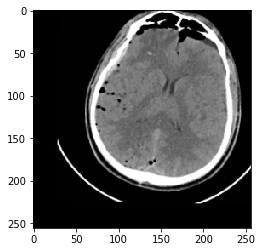

In [ ]:
# print the first image in X_train

img = X_train[7,:,:,:]
plt.imshow(img)

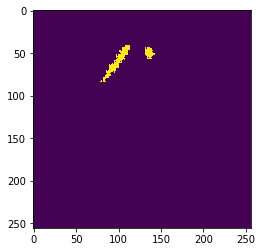

In [ ]:
# print the mask in Y_train

msk = Y_train[7,:,:,0]
plt.imshow(msk)

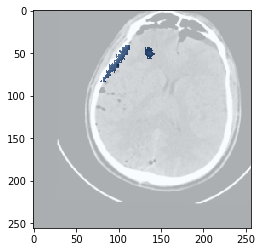

In [ ]:
plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

### [ 2 ] Val Generator

In [ ]:
def val_generator(batch_size=10):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_val.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_val
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_val[i] = image
            
            
            # Create Y_val
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_val[j] = mask
                
            
            # Normalize the images
            X_val = X_val/255
            
            yield X_val, Y_val

In [ ]:
# Test the generator

# initialize
val_gen = val_generator(batch_size=10)

# run the generator
X_val, Y_val = next(val_gen)

print(X_val.shape)
print(Y_val.shape)

(10, 256, 256, 3)
(10, 256, 256, 1)


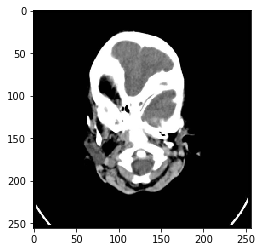

In [ ]:
# print the image from X_val

img = X_val[7,:,:,:]
plt.imshow(img)

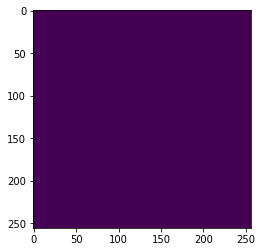

In [ ]:
# print the mask from Y_val

msk = Y_val[7,:,:,0]
plt.imshow(msk)

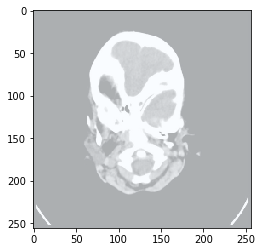

In [ ]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

### [ 3 ] Test Generator

In this test generator we will output both the test images (X_test) and the test masks (Y_test). 

In [ ]:
def test_generator(batch_size=1):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv('df_test.csv.gz', chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['new_image_fname'])
            mask_id_list = list(df['new_mask_fname'])
            
            # Create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_test = np.zeros((len(df), IMAGE_HEIGHT, IMAGE_WIDTH, 1), dtype=np.bool)
            


            
            # Create X_test
            #================
            
            for i, image_id in enumerate(image_id_list):
                

                # set the path to the image
                path = 'brain_image_dir/' + image_id

                # read the image
                image = cv2.imread(path)
           
                
                # convert to from BGR to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # insert the image into X_train
                X_test[i] = image
                
             
            # Create Y_test
            # ===============
                
            for j, mask_id in enumerate(mask_id_list):

                # set the path to the mask
                path = 'mask_dir/' + mask_id

                # read the mask
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # resize the mask
                mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))
                
                # expand dims from (800,600) to (800,600,1)
                mask = np.expand_dims(mask, axis=-1)
                
                
                
                
                # insert the image into Y_train
                Y_test[j] = mask
            
            
            # Normalize the images
            X_test = X_test/255
            
            yield X_test, Y_test


In [ ]:
# Test the generator

# initialize
test_gen = test_generator(batch_size=15)

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(15, 256, 256, 3)
(15, 256, 256, 1)


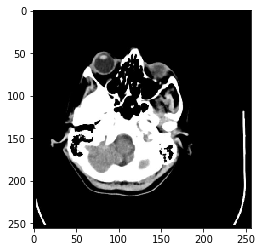

In [ ]:
# print the image from X_test

img = X_test[14,:,:,:]
plt.imshow(img)

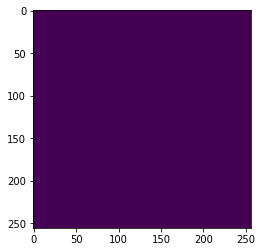

In [ ]:
# print the mask from Y_test

msk = Y_test[14,:,:,0]
plt.imshow(msk)

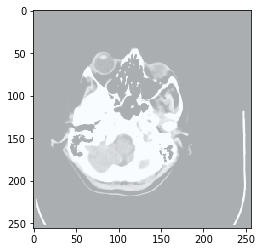

In [ ]:
# Combine the mask and the image

plt.imshow(img, cmap='gray')
plt.imshow(msk, cmap='Blues', alpha=0.7)

## Model Architecture

In [ ]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

from keras.callbacks import (EarlyStopping, ReduceLROnPlateau, 
                                        ModelCheckpoint, CSVLogger, LearningRateScheduler)


from keras.optimizers import Adam
from keras.losses import binary_crossentropy

from keras.initializers import he_normal 

import tensorflow as tf

In [ ]:
#! pip install segmentation-models

In [ ]:


from segmentation_models import Unet, FPN
from segmentation_models import  get_preprocessing # this line has an error in the docs

from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

from segmentation_models.losses import dice_loss
#from segmentation_models.metrics import dice_score

from segmentation_models.utils import set_trainable

In [ ]:
#preprocess = get_preprocessing('resnet101') # for resnet, img = (img-110.0)/1.0

BACKBONE = 'densenet121'
preprocess_input = get_preprocessing(BACKBONE)

# Note that the model takes 3-channel images as input
model = Unet(BACKBONE, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS), 
             #freeze_encoder=False,
             classes=1, 
             encoder_weights='imagenet',
             activation='sigmoid')

#model.summary()














29089792/29084464 [==============================] - 0s 0us/step



## Create X_test
Here we will use the test generator with a batch size of len(df_test) to create X_test and Y_test. Because the batch size is equal to the number of rows in df_test, the generator will ouput the entire
test set (100 rows) as a matrix.

In [ ]:
# initialize
test_gen = test_generator(batch_size=len(df_test))

# run the generator
X_test, Y_test = next(test_gen)

print(X_test.shape)
print(Y_test.shape)

(20, 256, 256, 3)
(20, 256, 256, 1)


## Train the Model

In [ ]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)

In [ ]:
# Initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)

model.compile(
    Adam(lr=0.0001),
    loss=dice_loss,
    metrics=[iou_score],
)



filepath = "model.h5"

earlystopper = EarlyStopping(patience=5, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, 
                                   verbose=1, mode='min')



log_fname = 'training_log.csv'
csv_logger = CSVLogger(filename=log_fname,
                       separator=',',
                       append=False)

callbacks_list = [checkpoint, earlystopper, csv_logger, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=40, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)




Epoch 1/40
211/211 [==============================] - 93s 442ms/step - loss: 0.9937 - iou_score: 0.0032 - val_loss: 0.9927 - val_iou_score: 0.0037

Epoch 00001: val_loss improved from inf to 0.99270, saving model to model.h5
Epoch 2/40
211/211 [==============================] - 52s 247ms/step - loss: 0.9870 - iou_score: 0.0066 - val_loss: 0.9848 - val_iou_score: 0.0078

Epoch 00002: val_loss improved from 0.99270 to 0.98478, saving model to model.h5
Epoch 3/40
211/211 [==============================] - 52s 246ms/step - loss: 0.9685 - iou_score: 0.0166 - val_loss: 0.9778 - val_iou_score: 0.0116

Epoch 00003: val_loss improved from 0.98478 to 0.97782, saving model to model.h5
Epoch 4/40
211/211 [==============================] - 53s 249ms/step - loss: 0.9145 - iou_score: 0.0486 - val_loss: 0.9794 - val_iou_score: 0.0106

Epoch 00004: val_loss did not improve from 0.97782
Epoch 5/40
211/211 [==============================] - 52s 246ms/step - loss: 0.8308 - iou_score: 0.1064 - val_loss:

In [ ]:
# save the model to google drive

Exp = 'Exp_13'

path_model = '/content/gdrive/My Drive/Colab/Kaggle/Intracranial_Hemorrhage_Analyzer/Segmentation_Experiments/' + Exp + '/model.h5'

model.load_weights('model.h5')

model.save(path_model)  

## Make a test set prediction

In [ ]:
# Make a prediction

# initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights('model.h5')
predictions = model.predict_generator(test_gen, 
                                      steps=len(df_test),  
                                      verbose=1)

20/20 [==============================] - 4s 216ms/step


In [ ]:
!ls

bone_image_dir	 df_test.csv.gz   gdrive    model.h5
brain_image_dir  df_train.csv.gz  input     sample_data
df_data.csv.gz	 df_val.csv.gz	  mask_dir  training_log.csv


### Threshold the predictions

The predictions are actually probabilities that a pixel is either part of a lung or part of the background. Here we threshold the predictions to convert all values to either 0 or 1.

We will use a threshold of 0.7. I got this number by trial and error - try a threshold value and look at the quality of the test set segmentations. 

In [ ]:
preds_test_thresh = (predictions >= 0.7).astype(np.uint8)

preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
1


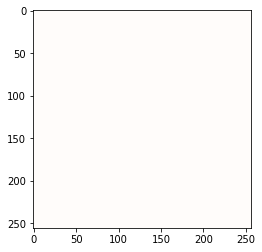

In [ ]:
# This is a predicted mask

mask = preds_test_thresh[3,:,:,0]
plt.imshow(mask, cmap='Reds', alpha=0.3)

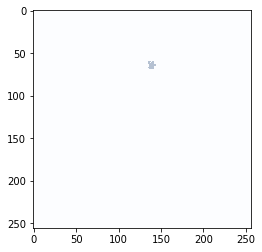

In [ ]:
# This is a true mask

true_mask = Y_test[3,:,:,0]
plt.imshow(true_mask, cmap='Blues', alpha=0.3)

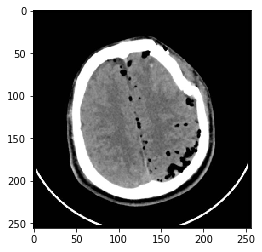

In [ ]:
# This is the x-ray image

image = X_test[3,:,:,:]

plt.imshow(image)

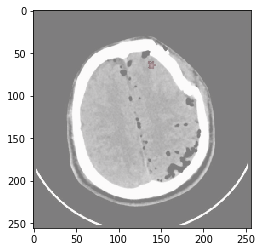

In [ ]:
# This is an overlay of the pred mask, true mask and 
# the x-ray image.

plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)

## Overlay pred masks, true masks and the x-ray image

Red - True Mask<br>
Blue - Pred Mask

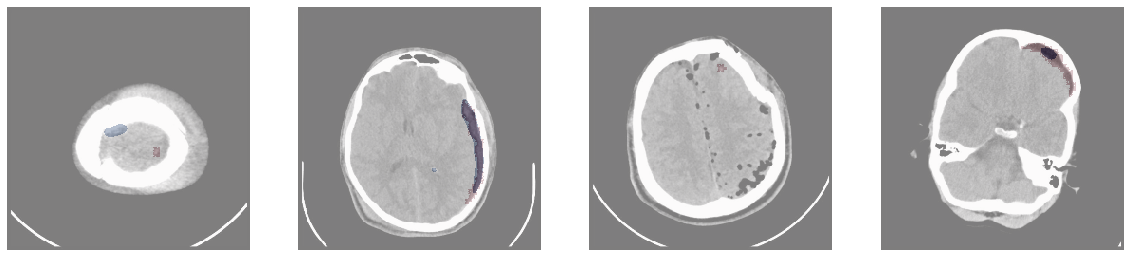

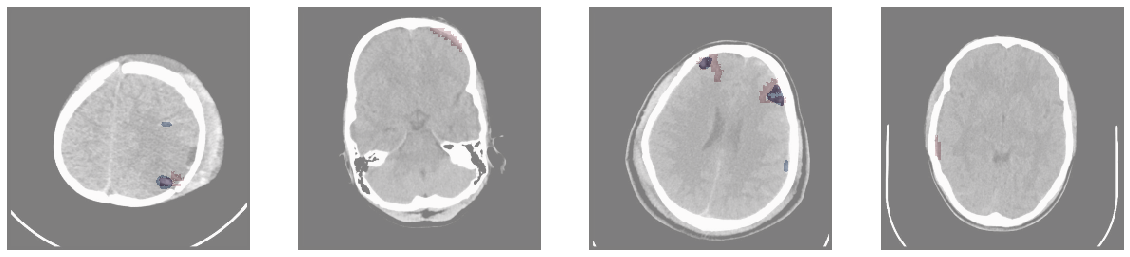

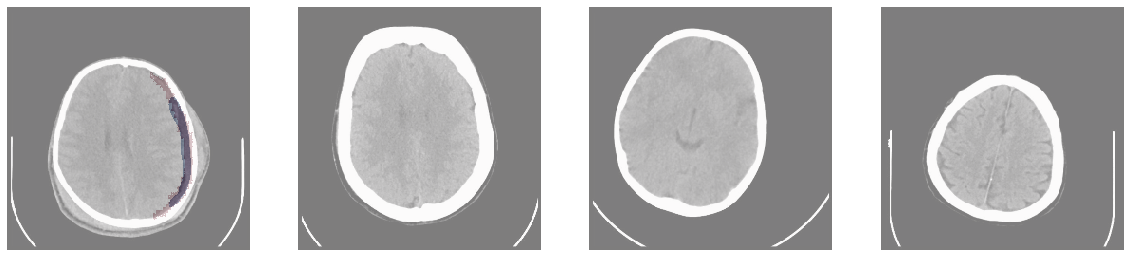

In [ ]:
# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')

predicted_masks = preds_test_thresh



    
# image
plt.subplot(1,4,1)
image = X_test[1,:,:,:] 
mask = predicted_masks[1, :, :, 0]
true_mask = Y_test[1, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[2,:,:,:] 
mask = predicted_masks[2, :, :, 0]
true_mask = Y_test[2, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[3,:,:,:]
mask = predicted_masks[3, :, :, 0]
true_mask = Y_test[3, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[4,:,:,:] 
mask = predicted_masks[4, :, :, 0]
true_mask = Y_test[4, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')



# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[5,:,:,:] 
mask = predicted_masks[5, :, :, 0]
true_mask = Y_test[5, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[6,:,:,:] 
mask = predicted_masks[6, :, :, 0]
true_mask = Y_test[6, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[7,:,:,:] 
mask = predicted_masks[7, :, :, 0]
true_mask = Y_test[7, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[8,:,:,:] 
mask = predicted_masks[8, :, :, 0]
true_mask = Y_test[8, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# ============ #


# set up the canvas for the subplots
plt.figure(figsize=(20,20))
plt.tight_layout()
plt.axis('Off')


# image
plt.subplot(1,4,1)
image = X_test[9,:,:,:] 
mask = predicted_masks[9, :, :, 0]
true_mask = Y_test[9, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,2)
image = X_test[10,:,:,:] 
mask = predicted_masks[10, :, :, 0]
true_mask = Y_test[10, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,3)
image = X_test[11,:,:,:] 
mask = predicted_masks[11, :, :, 0]
true_mask = Y_test[11, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


# image
plt.subplot(1,4,4)
image = X_test[12,:,:,:] 
mask = predicted_masks[12, :, :, 0]
true_mask = Y_test[12, :, :, 0]
plt.imshow(image, cmap='gray')
plt.imshow(true_mask, cmap='Reds', alpha=0.3)
plt.imshow(mask, cmap='Blues', alpha=0.3)
plt.axis('off')


plt.show()

## Convert the Model to Tensorflow.js

In [ ]:
# --ignore-installed is added to fix an error.

# https://stackoverflow.com/questions/49932759/pip-10-and-apt-how-to-avoid-cannot-uninstall
# -x-errors-for-distutils-packages

!pip install tensorflowjs --ignore-installed

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 412.3MB 36kB/s 
     |████████████████████████████████| 2.8MB 23.8MB/s 
     |████████████████████████████████| 17.3MB 199kB/s 
     |████████████████████████████████| 1.3MB 43.4MB/s 
     |████████████████████████████████| 512kB 37.7MB/s 
     |████████████████████████████████| 2.4MB 38.3MB/s 
     |████████████████████████████████| 112kB 55.7MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
     |████████████████████████████████| 61kB 8.7MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 3.8MB 25.2MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 256kB 49.3MB/s 
     |████████████████████████████████| 901kB 36.6MB/s 
     |████████████████████████████████| 696kB 47.9MB/s 
     |████████████████████████████████| 583kB 36.1MB/s 
    

In [ ]:
# Use the command line conversion tool to convert the model

!tensorflowjs_converter --input_format keras model.h5 tfjs/model

In [ ]:
# check that the folder containing the tfjs model files has been created
!ls

bone_image_dir	 df_test.csv.gz   gdrive    model.h5	 training_log.csv
brain_image_dir  df_train.csv.gz  input     sample_data
df_data.csv.gz	 df_val.csv.gz	  mask_dir  tfjs


In [ ]:
# Dowload the converted tfjs model folder - to my computer

# create a zip file
!zip -r /content/file.zip /content/tfjs

# download that zip file
from google.colab import files
files.download("/content/file.zip") # note: the name file.zip is correct

  adding: content/tfjs/ (stored 0%)
  adding: content/tfjs/model/ (stored 0%)
  adding: content/tfjs/model/group1-shard5of12.bin (deflated 6%)
  adding: content/tfjs/model/group1-shard12of12.bin (deflated 7%)
  adding: content/tfjs/model/group1-shard4of12.bin (deflated 7%)
  adding: content/tfjs/model/group1-shard2of12.bin (deflated 7%)
  adding: content/tfjs/model/group1-shard10of12.bin (deflated 8%)
  adding: content/tfjs/model/group1-shard9of12.bin (deflated 8%)
  adding: content/tfjs/model/group1-shard3of12.bin (deflated 7%)
  adding: content/tfjs/model/group1-shard1of12.bin (deflated 7%)
  adding: content/tfjs/model/model.json (deflated 96%)
  adding: content/tfjs/model/group1-shard11of12.bin (deflated 8%)
  adding: content/tfjs/model/group1-shard8of12.bin (deflated 8%)
  adding: content/tfjs/model/group1-shard6of12.bin (deflated 7%)
  adding: content/tfjs/model/group1-shard7of12.bin (deflated 8%)


> Con estos modelos ya podemos llamarlos en un app de javascript y listoooooo